In [1]:
import sys
sys.path.insert(0, '../..')

# general
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set()
warnings.filterwarnings("ignore")

# local
from sklearn_crfsuite import metrics
from core.stats import Statistics
from core.utils import load_dataset, format_number
from core.plots import plot_histogram, plot_learning_curve
from core.learning import LearningAnalyser
from core.reports import (
    compute_user_error,
    generate_comparison_report,
    generate_test_groups_comparison_report,
    generate_learning_report
)
from core.dataset import DatasetAnalyser, DatasetGroup

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

from core.latex import create_latex_tables_generator

import numpy as np
np.random.seed(3453562)

# 1. General statistics
## 1.1. Read data

In [2]:
df = load_dataset('../../data/ebay_items_attributes/ebay_items_attributes-dataset.csv')

### 1.1.1. Parse the attribute tags in IOB form

In [3]:
df['annotation__output'] = df['annotation__output'].apply(ast.literal_eval)
df['reference__output'] = df['reference__output'].apply(ast.literal_eval)

### 1.1.2. Simplify the beggining and inside tags

In [4]:
df['annotation__output'] = df['annotation__output'].apply(lambda tags:[t.split('-')[0] for t in tags])
df['reference__output'] = df['reference__output'].apply(lambda tags:[t.split('-')[0] for t in tags])

## 1.2. Statistics

In [5]:
stats = Statistics(df)

### 1.2.1. General

In [6]:
stats.general

,value
metric,
total_annotations,6779
unique_items,1871
unique_users,122
total_annotation_time,06h 16m 25s


### 1.2.2. Annotations per item

In [7]:
stats.annotations_per_item

,data__item_id
count,1871.000000
mean,3.623196
std,1.990264
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,22.000000


### 1.2.3. Annotations per user

In [8]:
stats.annotations_per_user

,user__id
count,122.000000
mean,55.565574
std,70.111952
min,12.000000
25%,22.000000
50%,49.000000
75%,50.000000
max,683.000000


### 1.2.4. Average annotation time over time

,value
index,
10,19.355967
20,19.816478
30,18.286692
40,18.361431
60,11.938329
70,17.637916
80,13.099505
90,10.849695


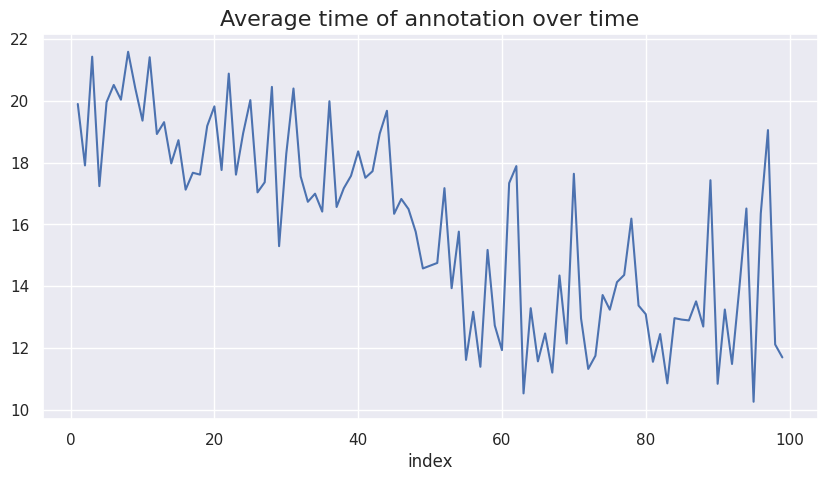

In [9]:
plt.figure(figsize=(10, 5))
plt.title("Average time of annotation over time", fontsize=16)
df_times = stats.average_time_per_annotation
df_times['value'].plot()
df_times[df_times.index % 10 == 0]

# 2. Confidence intervals
## 2.1. Compute user's annotation quality metrics
- In this section we aggregate the raw result to compute the quality metrics value per user
- To measure the quality of user's annotation we use: accuracy, recall, f1 and precision metrics
- Mean error is computed for each user in each test_group separately.<br/>
This way we can check how each user did in each test conditions

In [10]:
METRICS_COLUMNS = ["f1", "precision", "recall", "annotation_time", "count"]
LABELS = ["Brand", "Color", "Material", "Size", "Pattern", "Department"]

In [11]:
def metrics_function(y_true: pd.Series, y_pred: pd.Series):
    return {
        'precision': metrics.flat_precision_score(y_true, y_pred, average='weighted', labels=LABELS),
        'recall': metrics.flat_recall_score(y_true, y_pred, average='weighted', labels=LABELS),
        'f1': metrics.flat_f1_score(y_true, y_pred, average='weighted', labels=LABELS)
    }
  
    
df_user_error = compute_user_error(df, metrics_function)

## 2.2. Compute confidence intervals for test groups
In this section we compute the confidence intervals for the percentage quality change between the control group and each of the test groups.

In [12]:
dataset = DatasetAnalyser(df_user_error, METRICS_COLUMNS)

### 2.2.1. Compering: test groups vs control group

In [13]:
df_ci_h1, df_percentage_ci_h1, df_p_value_h1, df_cohen_d_h1 = generate_comparison_report(dataset)

#### Confidence intervals

In [14]:
df_ci_h1

f1  precision    recall  \
group_name              quantile                                  
high quality feedback   0.05      0.036737   0.069482  0.014805   
                        0.5       0.122438   0.150760  0.118547   
                        0.95      0.213035   0.233314  0.224031   
low quality feedback    0.05     -0.164984  -0.162817 -0.206705   
                        0.5      -0.003946  -0.015241 -0.007620   
                        0.95      0.154681   0.126623  0.190170   
medium quality feedback 0.05     -0.052852  -0.083185 -0.051864   
                        0.5       0.062634   0.036036  0.095854   
                        0.95      0.185965   0.164588  0.247721   

                                  annotation_time      count  
group_name              quantile                              
high quality feedback   0.05             0.227785 -31.988916  
                        0.5              5.730381 -10.477696  
                        0.95            11.694421   9.133902  
low quality feedback    0.05           -13.692621   1.181319  
                        0.5             -6.354169   5.170714  
                        0.95            -0.544806   9.786264  
medium quality feedback 0.05            -3.574291 -11.120238  
                        0.5              3.525992   6.315571  
                        0.95             9.974447  23.252381

#### Percentage confidence intervals

In [15]:
df_percentage_ci_h1

f1  precision    recall  \
group_name              quantile                                  
high quality feedback   0.05      0.187525   0.366852  0.059552   
                        0.5       0.624988   0.795990  0.476843   
                        0.95      1.087440   1.231864  0.901144   
low quality feedback    0.05     -0.528653  -0.513478 -0.561085   
                        0.5      -0.012644  -0.048066 -0.020683   
                        0.95      0.495638   0.399333  0.516204   
medium quality feedback 0.05     -0.200870  -0.276950 -0.173525   
                        0.5       0.238047   0.119975  0.320708   
                        0.95      0.706778   0.547970  0.828821   

                                  annotation_time     count  
group_name              quantile                             
high quality feedback   0.05             0.011523 -0.471041  
                        0.5              0.289879 -0.154285  
                        0.95             0.591578  0.134498  
low quality feedback    0.05            -0.641366  0.065350  
                        0.5             -0.297631  0.286040  
                        0.95            -0.025519  0.541368  
medium quality feedback 0.05            -0.187508 -0.384403  
                        0.5              0.184975  0.218316  
                        0.95             0.523262  0.803786

#### p-value

In [16]:
df_p_value_h1

,f1,precision,recall,annotation_time,count,group_name
0,0.9900,0.9994,0.9702,0.9569,0.2156,high quality feedback
0,0.4880,0.4375,0.4771,0.0343,0.9890,low quality feedback
0,0.8029,0.6770,0.8493,0.8184,0.7393,medium quality feedback


#### Cohen's D

In [17]:
df_cohen_d_h1

,f1,precision,recall,annotation_time,count,group_name
0,0.526137,0.693771,0.416994,0.402711,-0.144894,high quality feedback
0,-0.015717,-0.067043,-0.024201,-0.698937,0.749504,low quality feedback
0,0.296559,0.159536,0.369849,0.282499,0.211155,medium quality feedback


#### Ploting histograms for the difference: test groups vs control group

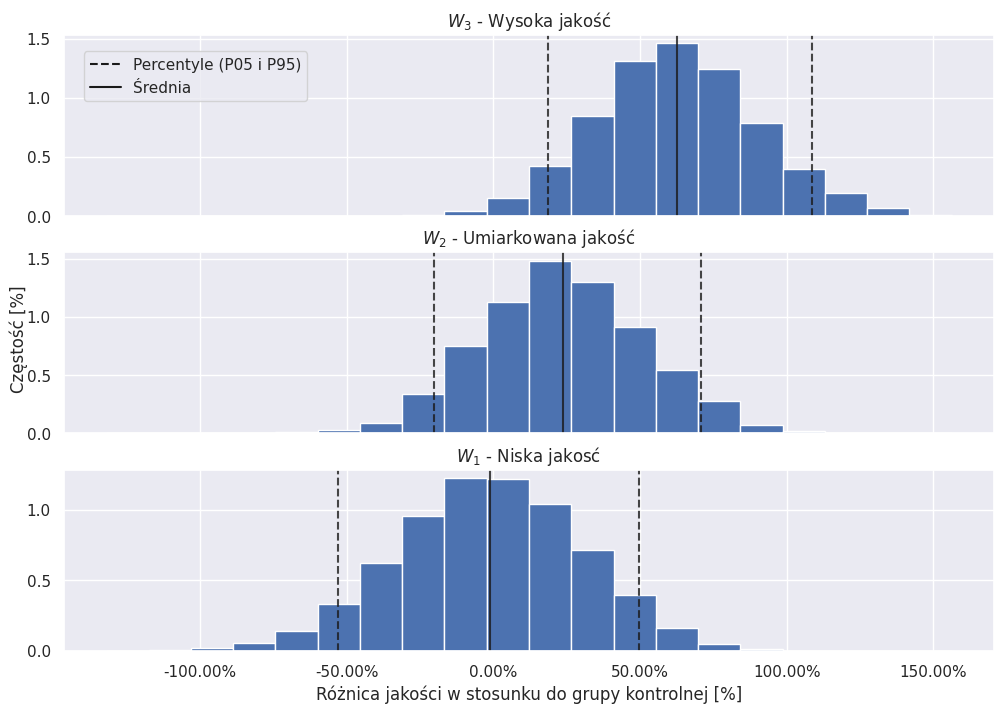

In [18]:
metric_index = 0
plot_histogram(dataset, metric_index)

### 2.2.2. Comparing: test groups with each other

In [19]:
df_ci_h2, df_p_value_h2, df_cohen_d_h2 = generate_test_groups_comparison_report(dataset)

#### Confidence interval

In [20]:
df_ci_h2

f1  precision    recall  annotation_time     count
group_name  quantile                                                          
high_low    0.05     -0.071575   0.190462 -0.220842         0.194512 -0.799164
            0.5       0.637632   0.844056  0.497527         0.587510 -0.440325
            0.95      1.359817   1.504892  1.216804         1.021246 -0.098973
high_medium 0.05     -0.256868   0.082350 -0.484943        -0.321209 -1.072791
            0.5       0.386941   0.676015  0.156135         0.104905 -0.372602
            0.95      1.042027   1.278627  0.792070         0.560902  0.290919
medium_low  0.05     -0.429364  -0.436383 -0.401950         0.023132 -0.711723
            0.5       0.250690   0.168041  0.341392         0.482606 -0.067723
            0.95      0.940198   0.793039  1.081652         0.946808  0.571367

#### p-value

In [21]:
df_p_value_h2

,f1,precision,recall,annotation_time,count,group_name
0,0.9310,0.9827,0.8736,0.9947,0.0169,high_low
0,0.8383,0.9685,0.6535,0.6427,0.1726,high_medium
0,0.7166,0.6650,0.7704,0.9578,0.4305,medium_low


#### Cohen's D

In [22]:
df_cohen_d_h2

,f1,precision,recall,annotation_time,count,group_name
0,2.176745,3.122612,1.694651,3.301261,-2.652172,high_low
0,1.414732,2.640933,0.557260,0.535063,-1.301496,high_medium
0,0.851460,0.635755,1.080589,2.420695,-0.246744,medium_low


# 3. Analyse learning curve

In [23]:
def get_annotation_eval(row):
    return metrics.flat_f1_score(
        [row['reference__output']], [row['annotation__output']],
        average='weighted',
        labels=LABELS
    )

df['annotation_eval'] = df.apply(get_annotation_eval, axis=1)
df_high = df.query("test_group == 'high quality feedback'")

In [24]:
learning = LearningAnalyser(df_high)

#### Learning curve stats

In [25]:
learning_report = generate_learning_report(learning)
learning_report

,Metryka,Wartość
0,$\alpha$,-0.001
1,$\beta$,0.21
2,$\alpha_r$,-30.56%
3,$\beta_r$,+104.26%


#### Learning curve plot

In [26]:
# styling fix
learning_report['Wartość'] = learning_report['Wartość'].astype(str).str.replace(".", ",")

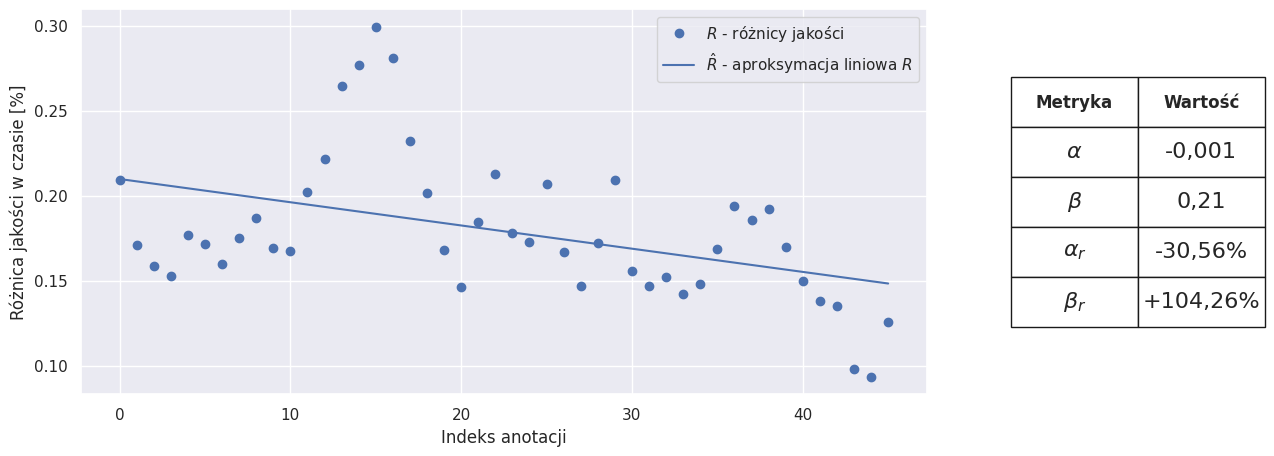

In [27]:
plot_learning_curve(learning, learning_report)

## Generate latex tables

In [28]:
latex_generator = create_latex_tables_generator(
    df_percentage_ci_h1=df_percentage_ci_h1,
    df_p_value_h1=df_p_value_h1,
    df_cohen_d_h1=df_cohen_d_h1,
    df_ci_h2=df_ci_h2,
    df_p_value_h2=df_p_value_h2,
    df_cohen_d_h2=df_cohen_d_h2
)

In [29]:
print(latex_generator.get_results_table("f1"))


\begin{table}[H]
\centering
\caption{}
\label{tab:my-table}
\begin{tabular}{cccccc}
\rowcolor[HTML]{EFEFEF} 
\multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\textbf{Warunek}} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{05}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$\mu$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{95}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$p$} &
  \boldmath$d$ \\ \hline
\rowcolor[HTML]{EFEFEF} 
\multicolumn{6}{c}{\cellcolor[HTML]{EFEFEF}Hipoteza $H_1$ -- zmiana w metryce XXXX}                                                                                                        \\ \hline
        \multicolumn{1}{c|}{$W_1$} & \multicolumn{1}{c|}{+18.75\%} & \multicolumn{1}{c|}{+62.50\%} & \multicolumn{1}{c|}{+108.74\%} & \multicolumn{1}{c|}{0.99} & 0.53 \\ \hline\multicolumn{1}{c|}{$W_2$} & \multicolumn{1}{c|}{-20.09\%} & \multicolumn{1}{c|}{+23.80\%} & \multicolumn{1}{c|}{+70.68\%} & \multicolumn{1}{c|